In [17]:
import os
from pathlib import Path
from typing import List, Optional
from collections import defaultdict

import matplotlib.pyplot as plt
import tensorflow as tf

# Hack the system path a little bit so we can import ..scripts.utils
import sys
sys.path.append('..')

from scripts import utils

In [42]:
OUTPUT_DIR = Path("../output")
DATA_DIR = Path("../data")

# Helper functions

In [28]:
# Path functions
def get_subdirs(d: Path) -> List[Path]:
    return [f for f in d.iterdir() if f.is_dir()]

def get_exp_paths(exp_name: str, *, most_recent=False) -> List[Path]:
    paths = DATA_DIR.glob(f"*{exp_name}*")
    paths = sorted(paths, key=os.path.getmtime, reverse=True)
    if most_recent:
        return [paths[0]]
    return paths

In [5]:
# Log functions

# https://github.com/franklinfrank/285project/blob/diff_ac/cs285/infrastructure/rl_trainer.py#L278-L301
def parse_tf_eventsfile(filename: str, *, tag='Eval_AverageReturn') -> List:
    eval_returns = []
    for e in tf.train.summary_iterator(filename):
        for v in e.summary.value:
            if v.tag == tag:
                eval_returns.append(v.simple_value)

    return eval_returns

# Plotting Code

In [43]:
DEFAULT_FIGSIZE = (12,10)

def plot_exp_set(exp_set_name):
    suite = defaultdict(list)
    for exp_flags in (utils.get_exp_flags(exp_set_name)):
        run_folder = get_exp_paths(utils.get_exp_name(exp_flags), most_recent=True)[0]
        logfile = str(list(run_folder.iterdir())[0])
        suite[exp_flags['env_name']].append(logfile)

    for env_name, exp_set in suite.items():
        plt.figure(figsize=DEFAULT_FIGSIZE)
        plt.title(env_name)
        for logfile in exp_set:
            y = parse_tf_eventsfile(logfile)
            plt.plot(y, label=logfile)
        plt.legend()
        plt.savefig(OUTPUT_DIR / f"{exp_set_name}__on__{env_name}")

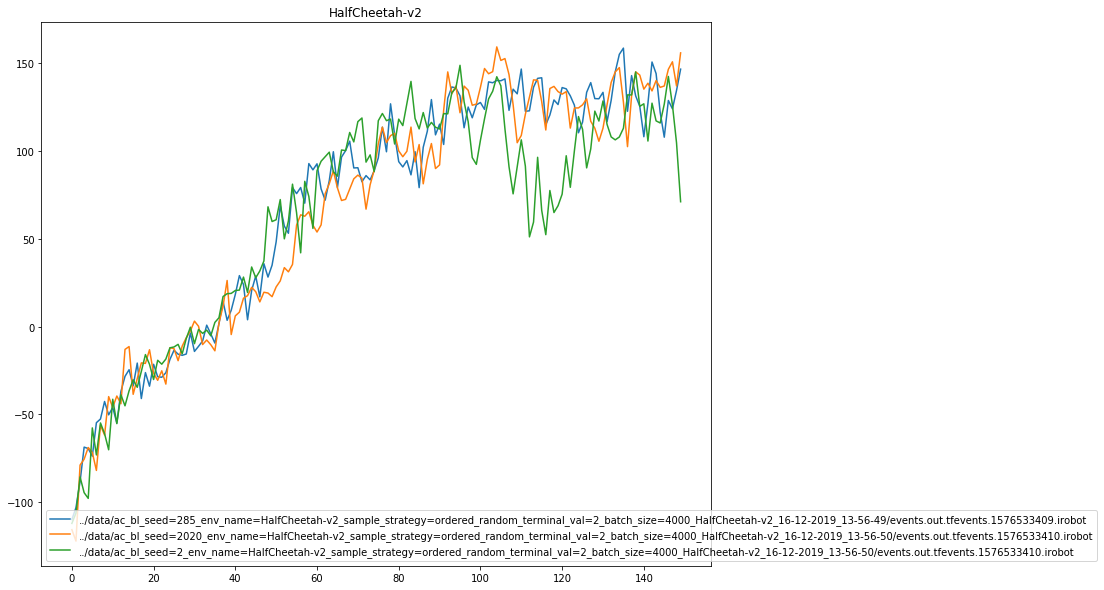

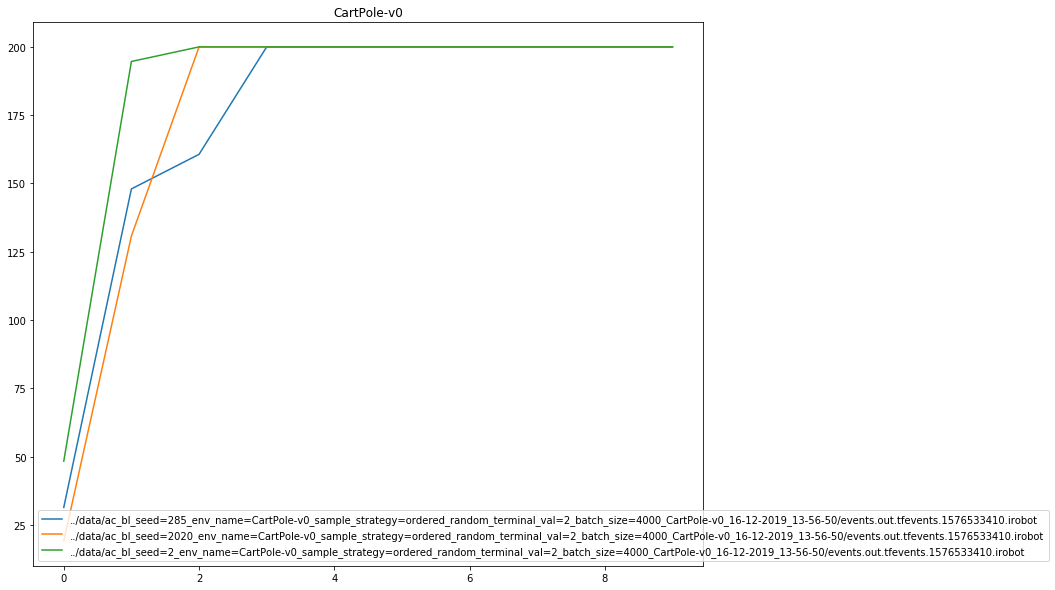

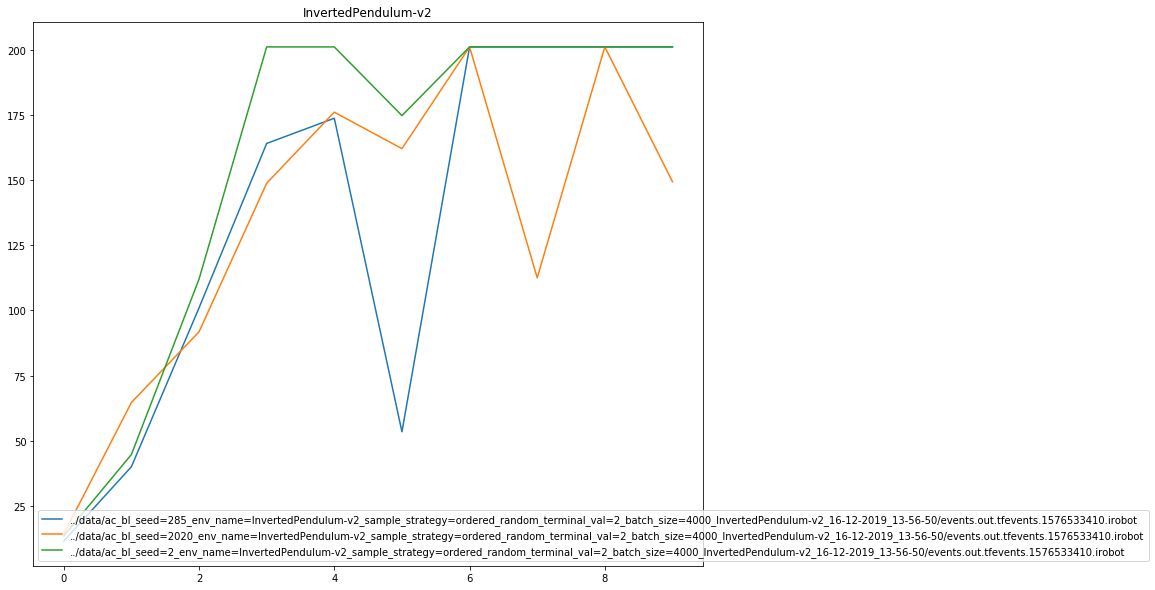

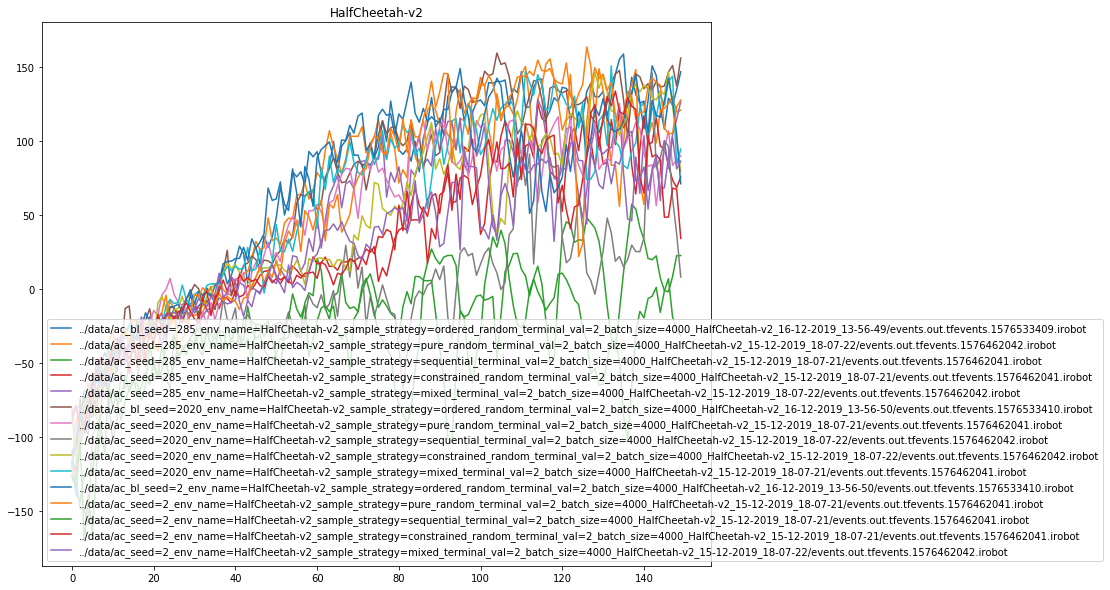

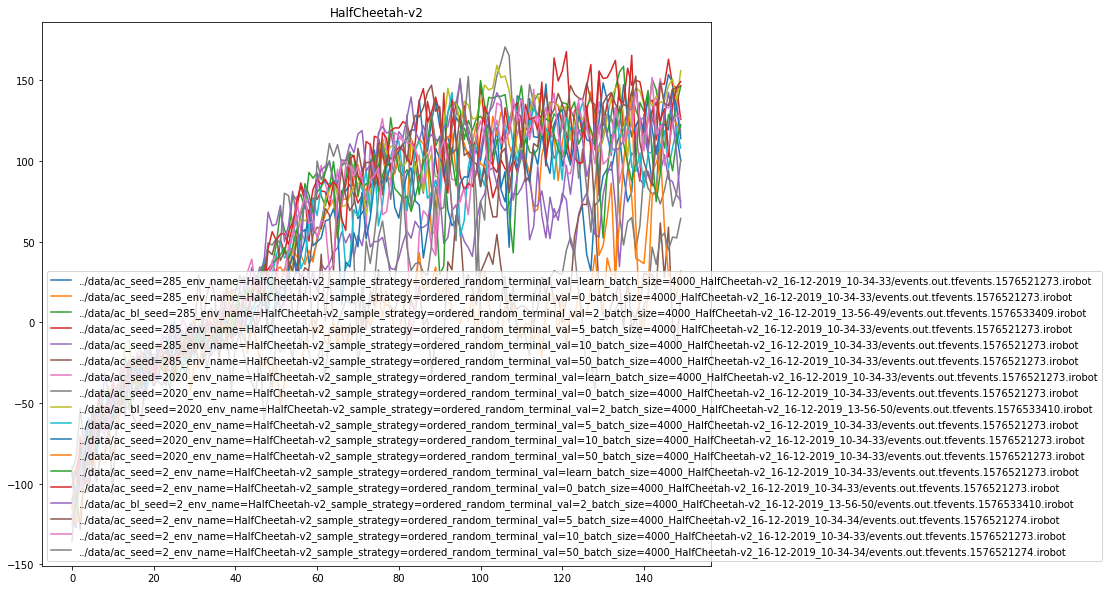

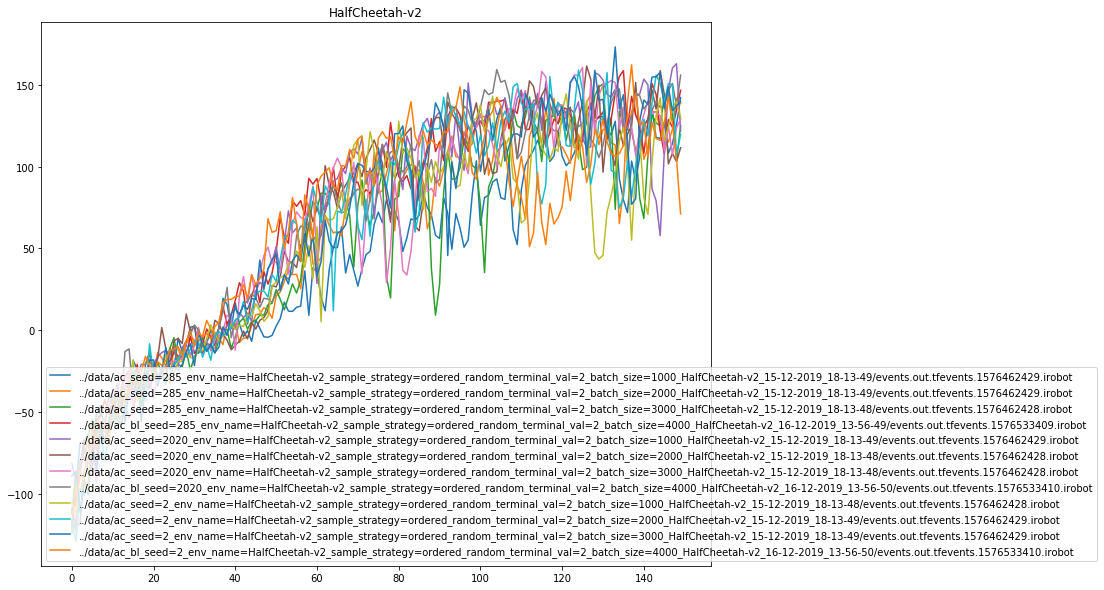

In [44]:
plot_exp_set('env_sweep')
plot_exp_set('sample_sweep')
plot_exp_set('terminal_val_sweep')
plot_exp_set('batch_size_sweep')